In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from fancyimpute import KNN    
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
weekly = pd.read_csv(filepath_or_buffer='Courier_weekly_data.csv')

In [4]:
weekly.head(20)

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,0.7632,7.340776,8,20.208158,5.236316,0.8158,43.384804,1,19
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,0.9459,11.883784,19,18.855405,5.689459,0.8919,35.078042,3,11
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,0.9302,7.072100,16,18.925116,5.138605,0.9302,31.455285,1,10
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,0.7727,7.356567,33,18.259697,4.704394,0.7879,34.252991,1,30
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,0.8889,8.501233,5,26.863704,4.828519,0.8889,46.478114,1,4
5,6282,3,-20,42,56,0.0536,0.9464,113.4821,0.0357,4777.0714,0.9107,8.210125,16,23.651786,5.553571,0.9107,79.407407,2,5
6,6282,4,9,22,32,0.1250,0.8750,105.0000,0.0938,5744.1875,0.8125,8.285422,12,18.180937,5.834375,0.7813,87.250000,1,2
7,6282,5,21,31,48,0.0417,0.9583,117.2500,0.0833,4011.7708,0.9167,9.768052,17,20.346667,5.615417,0.9167,85.083333,2,9
8,6282,6,-12,52,72,0.0694,0.9306,107.6389,0.0417,4000.3333,0.8472,7.736114,17,21.941111,5.093056,0.8750,73.904915,1,13
9,6282,7,1,40,56,0.0893,0.9107,124.3750,0.0893,3192.0000,0.9107,7.405355,11,18.591071,5.353214,0.9107,65.618750,2,4


In [5]:
weekly[(weekly.week==11) | (weekly.week==10) | (weekly.week==9)]['courier'].drop_duplicates().count()


387

In [7]:
weeks=weekly.copy()

In [8]:
def week_label(row):
    courier_set=weekly[(weekly.courier==row['courier']) & ((weekly.week==9) | (weekly.week==10) |(weekly.week==11))]
    if courier_set['courier'].count() == 0:
        label=1
    else: 
        label=0
    return label

In [10]:
weeks['label']=weeks.apply(week_label, axis=1)


In [11]:
weeks=weeks[(weeks.week<8)]

In [19]:
weeks.head(20)

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,label
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,0.7632,7.340776,8,20.208158,5.236316,0.8158,43.384804,1,19,1
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,0.9459,11.883784,19,18.855405,5.689459,0.8919,35.078042,3,11,1
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,0.9302,7.072100,16,18.925116,5.138605,0.9302,31.455285,1,10,1
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,0.7727,7.356567,33,18.259697,4.704394,0.7879,34.252991,1,30,1
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,0.8889,8.501233,5,26.863704,4.828519,0.8889,46.478114,1,4,0
5,6282,3,-20,42,56,0.0536,0.9464,113.4821,0.0357,4777.0714,0.9107,8.210125,16,23.651786,5.553571,0.9107,79.407407,2,5,0
6,6282,4,9,22,32,0.1250,0.8750,105.0000,0.0938,5744.1875,0.8125,8.285422,12,18.180937,5.834375,0.7813,87.250000,1,2,0
7,6282,5,21,31,48,0.0417,0.9583,117.2500,0.0833,4011.7708,0.9167,9.768052,17,20.346667,5.615417,0.9167,85.083333,2,9,0
8,6282,6,-12,52,72,0.0694,0.9306,107.6389,0.0417,4000.3333,0.8472,7.736114,17,21.941111,5.093056,0.8750,73.904915,1,13,0
9,6282,7,1,40,56,0.0893,0.9107,124.3750,0.0893,3192.0000,0.9107,7.405355,11,18.591071,5.353214,0.9107,65.618750,2,4,0


In [13]:
def max_consecutive(vector):
    longest = 0
    current = 0
    for num in vector:
        if num == 1:
            current += 1
        else:
            longest = max(longest, current)
            current = 0

    return max(longest, current)
    

In [22]:
max_consecutive([0,1,1,1,0,0,1,0,1,1,1,1,1,1,0])

6

In [29]:
def max_streak(series):
    week_vector=[0,0,0,0,0,0,0,0]
    
    for i in series:
        week_vector[i]=1
    streak=max_consecutive(week_vector)
    return streak
    
        
        

In [33]:
def lifetime_mean(series):
    return np.sum(series)/8

In [52]:
gold=weeks.groupby(['courier','label'], as_index=False ).agg({'week':['count', max_streak],'feature_1':['mean',lifetime_mean],'feature_2':['mean',lifetime_mean],'feature_3':['mean',lifetime_mean],'feature_4':['mean',lifetime_mean],'feature_5':['mean',lifetime_mean],'feature_6':['mean',lifetime_mean],'feature_7':['mean',lifetime_mean],'feature_8':['mean',lifetime_mean]})

In [53]:
weeks[(weeks.courier==101552)]

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,label
151,101552,0,17,85,96,0.0625,0.9375,115.4167,0.1146,2526.3125,0.8646,9.938890,38,19.448333,4.831042,0.8542,47.183007,5,12,0
152,101552,1,-12,102,98,0.0306,0.9694,122.8469,0.1735,2602.7653,0.8265,10.782992,41,19.302449,5.267857,0.8673,44.454521,4,23,0
153,101552,2,5,90,95,0.0737,0.9263,110.0632,0.2000,2614.3158,0.8632,10.320528,37,23.150000,4.762842,0.8842,48.739506,4,21,0
154,101552,3,-9,95,88,0.0341,0.9659,113.5682,0.1818,2583.0455,0.9205,9.580684,33,22.335909,4.818295,0.8977,39.243567,1,19,0
155,101552,4,14,86,75,0.0000,1.0000,121.9467,0.2667,2316.0000,0.9333,9.942443,30,21.335467,4.931467,1.0000,37.920543,2,6,0
156,101552,5,-13,100,107,0.0654,0.9346,118.7477,0.0374,2363.8318,0.8318,8.228350,38,21.186168,4.572243,0.8318,43.220833,5,17,0
157,101552,6,13,87,73,0.0411,0.9589,122.3973,0.0137,2294.2329,0.8767,8.809360,51,23.320411,4.752466,0.8356,31.955300,2,10,0
158,101552,7,-6,100,80,0.0375,0.9625,110.1375,0.0500,2481.0875,0.8500,8.936045,52,19.992125,4.389875,0.8625,32.114722,1,17,0


In [54]:
gold.columns = [gold + '_' + i for gold, i in zip(gold.columns.get_level_values(0), gold.columns.get_level_values(1).astype(str))]

In [58]:
gold=gold.rename(columns={'courier_':'courier','label_':'y'})

In [59]:
gold.columns

Index(['courier', 'y', 'week_count', 'week_max_streak', 'feature_1_mean',
       'feature_1_lifetime_mean', 'feature_2_mean', 'feature_2_lifetime_mean',
       'feature_3_mean', 'feature_3_lifetime_mean', 'feature_4_mean',
       'feature_4_lifetime_mean', 'feature_5_mean', 'feature_5_lifetime_mean',
       'feature_6_mean', 'feature_6_lifetime_mean', 'feature_7_mean',
       'feature_7_lifetime_mean', 'feature_8_mean', 'feature_8_lifetime_mean'],
      dtype='object')

In [60]:
gold.set_index('courier', inplace=True)

In [62]:
golden_x= gold.drop(['y'], axis=1)
golden_y= gold['y']

In [63]:
x_train, x_test, y_train, y_test = train_test_split(golden_x,golden_y , test_size=0.25)

In [64]:
golden_y.value_counts()


0    365
1    364
Name: y, dtype: int64

In [68]:
clf = LogisticRegression()

In [69]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X=x_train, y=y_train)
test_y_pred = logisticRegr.predict(x_test)
cf_mt = confusion_matrix(y_test, test_y_pred)
print('Intercept: ' + str(logisticRegr.intercept_))
print('Regression: ' + str(logisticRegr.coef_))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr.score(x_test, y_test)))
print(classification_report(y_test, test_y_pred))

Intercept: [-0.00539862]
Regression: [[-8.28215518e-02  4.58555275e-01 -2.48117531e-02 -1.32445437e-01
  -4.26974532e-03  4.50452698e-03 -3.66007369e-02 -5.32518367e-03
   1.23170008e-02  1.05280560e-02 -1.77169318e-02 -2.08815932e-02
   2.39859665e-02 -5.20528515e-02 -5.96401155e-02 -2.03003502e-02
  -2.34751120e-06  2.74612884e-04]]
Accuracy of logistic regression classifier on test set: 0.78
             precision    recall  f1-score   support

          0       0.78      0.80      0.79        93
          1       0.78      0.77      0.78        90

avg / total       0.78      0.78      0.78       183



Text(0.5,15,'Predicted label')

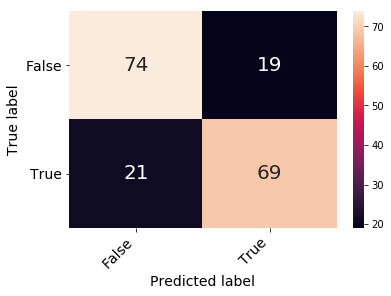

In [70]:
confusion_matrix_df = pd.DataFrame(cf_mt, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

0.7814207650273224
Accuracy: 0.775 (0.069)
Logloss: -0.482 (0.152)
AUC: 0.875 (0.077)
[[74 19]
 [21 69]]


Text(0.5,15,'Predicted label')

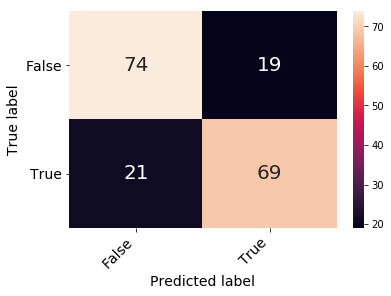

In [71]:
clf.fit(x_train,y_train)
print(clf.score(x_test, y_test))
seed = 7
k_fold = KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'
results = results=cross_val_score(clf, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'neg_log_loss'
results = results=cross_val_score(clf, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Logloss: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'roc_auc'
results = results=cross_val_score(clf, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)


confusion_matrix_df = pd.DataFrame(matrix, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

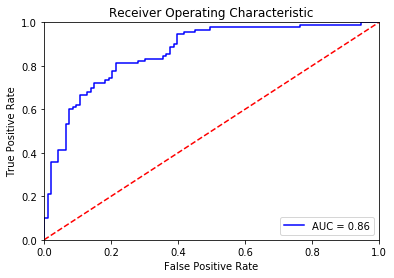

In [73]:
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

0.7814207650273224
Accuracy: 0.782 (0.060)
Logloss: -0.467 (0.119)
AUC: 0.879 (0.072)


Text(0.5,15,'Predicted label')

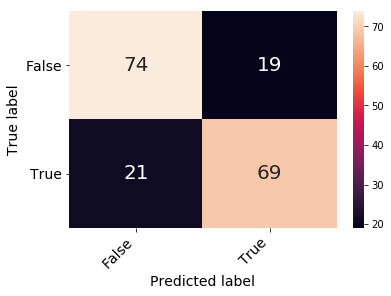

In [74]:
penalty = ['l2']
#C = np.logspace(0, 4, 10)
C = uniform(loc=0, scale=4)
hyperparameters = dict(C=C, penalty=penalty)

#clf_CV = GridSearchCV(clf, hyperparameters, cv=5, verbose=0)
clf_CV = RandomizedSearchCV(clf, hyperparameters, random_state=1, n_iter=10, cv=5, verbose=0, n_jobs=-1)
best_model = clf_CV.fit(x_train, y_train)
clf_CV.fit(x_train,y_train)
print(clf_CV.score(x_test, y_test))
seed = 7
k_fold = KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'
results = results=cross_val_score(clf_CV, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'neg_log_loss'
results = results=cross_val_score(clf_CV, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Logloss: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'roc_auc'
results = results=cross_val_score(clf_CV, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

predicted=best_model.predict(x_test)
matrix = confusion_matrix(y_test, predicted)


confusion_matrix_df = pd.DataFrame(matrix, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

0.7814207650273224


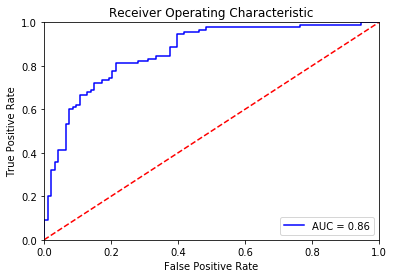

In [75]:

probs = best_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

print(accuracy_score(y_test, predicted))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [76]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [77]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train.values, y_train.values)

    
    y_pred = grid_search.predict(x_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [78]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')


JoblibException: JoblibException
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000028E180A6DB0, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\huartesa\AppData\Local\Continuum\anacon...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\h...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000028E180A6DB0, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\huartesa\AppData\Local\Continuum\anacon...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\h...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "grid_search_clf = grid_search_wrapper(refit_score='precision_score')\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 29, 14, 17, 11, 74099, tzinfo=tzutc()), 'msg_id': '6EFB5FBECDF0461F81A491A6AF62F20B', 'msg_type': 'execute_request', 'session': 'B6D358B33BA14A83935DFEDC7485FFB8', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6EFB5FBECDF0461F81A491A6AF62F20B', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'B6D358B33BA14A83935DFEDC7485FFB8']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "grid_search_clf = grid_search_wrapper(refit_score='precision_score')\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 29, 14, 17, 11, 74099, tzinfo=tzutc()), 'msg_id': '6EFB5FBECDF0461F81A491A6AF62F20B', 'msg_type': 'execute_request', 'session': 'B6D358B33BA14A83935DFEDC7485FFB8', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6EFB5FBECDF0461F81A491A6AF62F20B', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'B6D358B33BA14A83935DFEDC7485FFB8'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "grid_search_clf = grid_search_wrapper(refit_score='precision_score')\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 29, 14, 17, 11, 74099, tzinfo=tzutc()), 'msg_id': '6EFB5FBECDF0461F81A491A6AF62F20B', 'msg_type': 'execute_request', 'session': 'B6D358B33BA14A83935DFEDC7485FFB8', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6EFB5FBECDF0461F81A491A6AF62F20B', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="grid_search_clf = grid_search_wrapper(refit_score='precision_score')\n", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "grid_search_clf = grid_search_wrapper(refit_score='precision_score')\n"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("grid_search_clf = grid_search_wrapper(refit_score='precision_score')\n",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("grid_search_clf = grid_search_wrapper(refit_score='precision_score')\n",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="grid_search_clf = grid_search_wrapper(refit_score='precision_score')\n", store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-78-bc150bd7f799>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 28e24146d68, executio..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000028E2470E930, file "<ipython-input-78-bc150bd7f799>", line 1>
        result = <ExecutionResult object at 28e24146d68, executio..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000028E2470E930, file "<ipython-input-78-bc150bd7f799>", line 1>, result=<ExecutionResult object at 28e24146d68, executio..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000028E2470E930, file "<ipython-input-78-bc150bd7f799>", line 1>
        self.user_global_ns = {'C': <scipy.stats._distn_infrastructure.rv_frozen object>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport ma...accuracy_score, precision_score, confusion_matrix', "get_ipython().magic('matplotlib inline')", "weekly = pd.read_csv(filepath_or_buffer='Courier_weekly_data.csv')", 'weekly.head(20)', "weekly[(weekly.week==11) | (weekly.week==10) | (...ly.week==9)]['courier'].drop_duplicates().count()", '\ndef week_label(row):\n    courier_set=weekly[(we...bel=1\n    else: \n        label=0\n    return label', 'weeks=weekly.copy()', '\ndef week_label(row):\n    courier_set=weekly[(we...bel=1\n    else: \n        label=0\n    return label', "week['label']=week.apply(week_label, axis=1)", "weeks['label']=weeks.apply(week_label, axis=1)", 'weeks=weeks[(weeks.week<8)]', 'weeks.head()', 'def max_consecutive(vector):\n    longest = 0\n   ...urrent = 0\n\n    return max(longest, current)\n    ', 'def max_streak(series):\n    week_vector=[0,0,0,0..._vector)\n    return streak\n    \n        \n        ', "gold=weeks.groupby(['courier'], as_index=False ).agg({week:[count, max_consecutive]})", "gold=weeks.groupby(['courier'], as_index=False ).agg({'week':[count, max_consecutive]})", "gold=weeks.groupby(['courier'], as_index=False ).agg({'week':['count', max_consecutive]})", 'gold', 'weeks.head(20)', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'KNN': <class 'fancyimpute.knn.KNN'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {4:     courier  week  feature_1  feature_2  feature...     0.8732   47.096181           1           9  , 5: 387, 12:    courier  week  feature_1  feature_2  feature_...  1  
1      1  
2      1  
3      1  
4      0  , 18:     courier  week                
            co...341     3               0

[729 rows x 3 columns], 19:     courier  week  feature_1  feature_2  feature... 
23      1  
24      1  
25      1  
26      1  , 20: 4, 21: 3, 22: 6, 25:     courier  week                
            co...341     3               0

[729 rows x 3 columns], 28:     courier  week           
            count m...  519341     3          2

[729 rows x 3 columns], ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
        self.user_ns = {'C': <scipy.stats._distn_infrastructure.rv_frozen object>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport ma...accuracy_score, precision_score, confusion_matrix', "get_ipython().magic('matplotlib inline')", "weekly = pd.read_csv(filepath_or_buffer='Courier_weekly_data.csv')", 'weekly.head(20)', "weekly[(weekly.week==11) | (weekly.week==10) | (...ly.week==9)]['courier'].drop_duplicates().count()", '\ndef week_label(row):\n    courier_set=weekly[(we...bel=1\n    else: \n        label=0\n    return label', 'weeks=weekly.copy()', '\ndef week_label(row):\n    courier_set=weekly[(we...bel=1\n    else: \n        label=0\n    return label', "week['label']=week.apply(week_label, axis=1)", "weeks['label']=weeks.apply(week_label, axis=1)", 'weeks=weeks[(weeks.week<8)]', 'weeks.head()', 'def max_consecutive(vector):\n    longest = 0\n   ...urrent = 0\n\n    return max(longest, current)\n    ', 'def max_streak(series):\n    week_vector=[0,0,0,0..._vector)\n    return streak\n    \n        \n        ', "gold=weeks.groupby(['courier'], as_index=False ).agg({week:[count, max_consecutive]})", "gold=weeks.groupby(['courier'], as_index=False ).agg({'week':[count, max_consecutive]})", "gold=weeks.groupby(['courier'], as_index=False ).agg({'week':['count', max_consecutive]})", 'gold', 'weeks.head(20)', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'KNN': <class 'fancyimpute.knn.KNN'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {4:     courier  week  feature_1  feature_2  feature...     0.8732   47.096181           1           9  , 5: 387, 12:    courier  week  feature_1  feature_2  feature_...  1  
1      1  
2      1  
3      1  
4      0  , 18:     courier  week                
            co...341     3               0

[729 rows x 3 columns], 19:     courier  week  feature_1  feature_2  feature... 
23      1  
24      1  
25      1  
26      1  , 20: 4, 21: 3, 22: 6, 25:     courier  week                
            co...341     3               0

[729 rows x 3 columns], 28:     courier  week           
            count m...  519341     3          2

[729 rows x 3 columns], ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
C:\Users\huartesa\Documents\other\jobs\Data_Scientist_Interview\<ipython-input-78-bc150bd7f799> in <module>()
----> 1 grid_search_clf = grid_search_wrapper(refit_score='precision_score')

...........................................................................
C:\Users\huartesa\Documents\other\jobs\Data_Scientist_Interview\<ipython-input-77-469f35795da2> in grid_search_wrapper(refit_score='precision_score')
      4     prints classifier performance metrics
      5     """
      6     skf = StratifiedKFold(n_splits=10)
      7     grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
      8                            cv=skf, return_train_score=True, n_jobs=-1)
----> 9     grid_search.fit(x_train.values, y_train.values)
     10 
     11     
     12     y_pred = grid_search.predict(x_test.values)
     13 

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=10, ran...: make_scorer(accuracy_score)},
       verbose=0), X=array([[ 8.00000000e+00,  8.00000000e+00,  2.500...00000000e+00,  2.45666670e+03,  3.07083338e+02]]), y=array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,...1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int64), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...d(n_splits=10, random_state=None, shuffle=False)>
        X = array([[ 8.00000000e+00,  8.00000000e+00,  2.500...00000000e+00,  2.45666670e+03,  3.07083338e+02]])
        y = array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,...1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int64)
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
JoblibValueError                                   Fri Mar 29 15:18:23 2019
PID: 19924Python 3.6.3: C:\Users\huartesa\AppData\Local\Continuum\anaconda3\python.exe
...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), array([[ 8.00000000e+00,  8.00000000e+00,  2.500...00000000e+00,  2.45666670e+03,  3.07083338e+02]]), array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,...1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int64), {'accuracy_score': make_scorer(accuracy_score), 'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)}, array([ 49,  50,  53,  57,  60,  61,  62,  63,  ...    537, 538, 539, 540, 541, 542, 543, 544, 545]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 46, 47, 48, 51, 52,
       54, 55, 56, 58, 59]), 0, {'max_depth': 3, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 100}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), array([[ 8.00000000e+00,  8.00000000e+00,  2.500...00000000e+00,  2.45666670e+03,  3.07083338e+02]]), array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,...1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int64), {'accuracy_score': make_scorer(accuracy_score), 'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)}, array([ 49,  50,  53,  57,  60,  61,  62,  63,  ...    537, 538, 539, 540, 541, 542, 543, 544, 545]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 46, 47, 48, 51, 52,
       54, 55, 56, 58, 59]), 0, {'max_depth': 3, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 100})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=array([[ 8.00000000e+00,  8.00000000e+00,  2.500...00000000e+00,  2.45666670e+03,  3.07083338e+02]]), y=array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,...1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int64), scorer={'accuracy_score': make_scorer(accuracy_score), 'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)}, train=array([ 49,  50,  53,  57,  60,  61,  62,  63,  ...    537, 538, 539, 540, 541, 542, 543, 544, 545]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 46, 47, 48, 51, 52,
       54, 55, 56, 58, 59]), verbose=0, parameters={'max_depth': 3, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 100}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestClas...e=None, verbose=0,
            warm_start=False)>
        X_train = array([[ 2.00000000e+00,  1.00000000e+00, -5.000...00000000e+00,  2.45666670e+03,  3.07083338e+02]])
        y_train = array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,..., 0, 0, 1,
       0, 1, 1, 0, 0, 1], dtype=int64)
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=array([[ 2.0000000e+00,  1.0000000e+00, -5.00000...  2.4566667e+03,  3.0708334e+02]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       [0...    [1.],
       [0.],
       [0.],
       [1.]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 99
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in retrieve(self=Parallel(n_jobs=-1))
    735 %s""" % (this_report, exception.message)
    736                     # Convert this to a JoblibException
    737                     exception_type = _mk_exception(exception.etype)[0]
    738                     exception = exception_type(report)
    739 
--> 740                     raise exception
        exception = undefined
    741 
    742     def __call__(self, iterable):
    743         if self._jobs:
    744             raise ValueError('This Parallel instance is already running')

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\huartesa\Documents\other\jobs\Data_Scientist_Interview\<string> in <module>()

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\multiprocessing\spawn.py in spawn_main(pipe_handle=2628, parent_pid=15660, tracker_fd=None)
    100         fd = msvcrt.open_osfhandle(new_handle, os.O_RDONLY)
    101     else:
    102         from . import semaphore_tracker
    103         semaphore_tracker._semaphore_tracker._fd = tracker_fd
    104         fd = pipe_handle
--> 105     exitcode = _main(fd)
        exitcode = undefined
        fd = 3
    106     sys.exit(exitcode)
    107 
    108 
    109 def _main(fd):

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\multiprocessing\spawn.py in _main(fd=3)
    113             preparation_data = reduction.pickle.load(from_parent)
    114             prepare(preparation_data)
    115             self = reduction.pickle.load(from_parent)
    116         finally:
    117             del process.current_process()._inheriting
--> 118     return self._bootstrap()
        self._bootstrap = <bound method BaseProcess._bootstrap of <SpawnProcess(SpawnPoolWorker-129, started daemon)>>
    119 
    120 
    121 def _check_not_importing_main():
    122     if getattr(process.current_process(), '_inheriting', False):

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\multiprocessing\process.py in _bootstrap(self=<SpawnProcess(SpawnPoolWorker-129, started daemon)>)
    253                 # delay finalization of the old process object until after
    254                 # _run_after_forkers() is executed
    255                 del old_process
    256             util.info('child process calling self.run()')
    257             try:
--> 258                 self.run()
        self.run = <bound method BaseProcess.run of <SpawnProcess(SpawnPoolWorker-129, started daemon)>>
    259                 exitcode = 0
    260             finally:
    261                 util._exit_function()
    262         except SystemExit as e:

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\multiprocessing\process.py in run(self=<SpawnProcess(SpawnPoolWorker-129, started daemon)>)
     88     def run(self):
     89         '''
     90         Method to be run in sub-process; can be overridden in sub-class
     91         '''
     92         if self._target:
---> 93             self._target(*self._args, **self._kwargs)
        self._target = <function worker>
        self._args = (<sklearn.externals.joblib.pool.CustomizablePicklingQueue object>, <sklearn.externals.joblib.pool.CustomizablePicklingQueue object>, None, (), None, True)
        self._kwargs = {}
     94 
     95     def start(self):
     96         '''
     97         Start child process

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\multiprocessing\pool.py in worker(inqueue=<sklearn.externals.joblib.pool.CustomizablePicklingQueue object>, outqueue=<sklearn.externals.joblib.pool.CustomizablePicklingQueue object>, initializer=None, initargs=(), maxtasks=None, wrap_exception=True)
    114             util.debug('worker got sentinel -- exiting')
    115             break
    116 
    117         job, i, func, args, kwds = task
    118         try:
--> 119             result = (True, func(*args, **kwds))
        result = None
        func = <sklearn.externals.joblib._parallel_backends.SafeFunction object>
        args = ()
        kwds = {}
    120         except Exception as e:
    121             if wrap_exception and func is not _helper_reraises_exception:
    122                 e = ExceptionWithTraceback(e, e.__traceback__)
    123             result = (False, e)

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in __call__(self=<sklearn.externals.joblib._parallel_backends.SafeFunction object>, *args=(), **kwargs={})
    345     def __init__(self, func):
    346         self.func = func
    347 
    348     def __call__(self, *args, **kwargs):
    349         try:
--> 350             return self.func(*args, **kwargs)
        self.func = <sklearn.externals.joblib.parallel.BatchedCalls object>
        args = ()
        kwargs = {}
    351         except KeyboardInterrupt:
    352             # We capture the KeyboardInterrupt and reraise it as
    353             # something different, as multiprocessing does not
    354             # interrupt processing for a KeyboardInterrupt

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), array([[ 8.00000000e+00,  8.00000000e+00,  2.500...00000000e+00,  2.45666670e+03,  3.07083338e+02]]), array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,...1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int64), {'accuracy_score': make_scorer(accuracy_score), 'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)}, array([ 49,  50,  53,  57,  60,  61,  62,  63,  ...    537, 538, 539, 540, 541, 542, 543, 544, 545]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 46, 47, 48, 51, 52,
       54, 55, 56, 58, 59]), 0, {'max_depth': 3, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 100}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), array([[ 8.00000000e+00,  8.00000000e+00,  2.500...00000000e+00,  2.45666670e+03,  3.07083338e+02]]), array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,...1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int64), {'accuracy_score': make_scorer(accuracy_score), 'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)}, array([ 49,  50,  53,  57,  60,  61,  62,  63,  ...    537, 538, 539, 540, 541, 542, 543, 544, 545]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 46, 47, 48, 51, 52,
       54, 55, 56, 58, 59]), 0, {'max_depth': 3, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 100})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=array([[ 8.00000000e+00,  8.00000000e+00,  2.500...00000000e+00,  2.45666670e+03,  3.07083338e+02]]), y=array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,...1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int64), scorer={'accuracy_score': make_scorer(accuracy_score), 'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)}, train=array([ 49,  50,  53,  57,  60,  61,  62,  63,  ...    537, 538, 539, 540, 541, 542, 543, 544, 545]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 46, 47, 48, 51, 52,
       54, 55, 56, 58, 59]), verbose=0, parameters={'max_depth': 3, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 100}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestClas...e=None, verbose=0,
            warm_start=False)>
        X_train = array([[ 2.00000000e+00,  1.00000000e+00, -5.000...00000000e+00,  2.45666670e+03,  3.07083338e+02]])
        y_train = array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,..., 0, 0, 1,
       0, 1, 1, 0, 0, 1], dtype=int64)
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=array([[ 2.0000000e+00,  1.0000000e+00, -5.00000...  2.4566667e+03,  3.0708334e+02]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       [0...    [1.],
       [0.],
       [0.],
       [1.]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 99
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Mar 29 15:18:21 2019
PID: 19924Python 3.6.3: C:\Users\huartesa\AppData\Local\Continuum\anaconda3\python.exe
...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeClassifier(class_weight=None, criter...         random_state=815305645, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), array([[ 2.0000000e+00,  1.0000000e+00, -5.00000...  2.4566667e+03,  3.0708334e+02]], dtype=float32), array([[0.],
       [0.],
       [0.],
       [0...    [1.],
       [0.],
       [0.],
       [1.]]), None, 0, 100), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeClassifier(class_weight=None, criter...         random_state=815305645, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), array([[ 2.0000000e+00,  1.0000000e+00, -5.00000...  2.4566667e+03,  3.0708334e+02]], dtype=float32), array([[0.],
       [0.],
       [0.],
       [0...    [1.],
       [0.],
       [0.],
       [1.]]), None, 0, 100)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py in _parallel_build_trees(tree=DecisionTreeClassifier(class_weight=None, criter...         random_state=815305645, splitter='best'), forest=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=array([[ 2.0000000e+00,  1.0000000e+00, -5.00000...  2.4566667e+03,  3.0708334e+02]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       [0...    [1.],
       [0.],
       [0.],
       [1.]]), sample_weight=None, tree_idx=0, n_trees=100, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeClassifier.fit of Deci...        random_state=815305645, splitter='best')>
        X = array([[ 2.0000000e+00,  1.0000000e+00, -5.00000...  2.4566667e+03,  3.0708334e+02]], dtype=float32)
        y = array([[0.],
       [0.],
       [0.],
       [0...    [1.],
       [0.],
       [0.],
       [1.]])
        sample_weight = None
        curr_sample_weight = array([1., 2., 1., 3., 1., 0., 2., 2., 0., 2., 2... 1., 2., 3., 4., 1., 0., 0., 2., 1., 1., 1., 1.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...         random_state=815305645, splitter='best'), X=array([[ 2.0000000e+00,  1.0000000e+00, -5.00000...  2.4566667e+03,  3.0708334e+02]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       [0...    [1.],
       [0.],
       [0.],
       [1.]]), sample_weight=array([1., 2., 1., 3., 1., 0., 2., 2., 0., 2., 2... 1., 2., 3., 4., 1., 0., 0., 2., 1., 1., 1., 1.]), check_input=False, X_idx_sorted=None)
    785 
    786         super(DecisionTreeClassifier, self).fit(
    787             X, y,
    788             sample_weight=sample_weight,
    789             check_input=check_input,
--> 790             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
    791         return self
    792 
    793     def predict_proba(self, X, check_input=True):
    794         """Predict class probabilities of the input samples X.

...........................................................................
C:\Users\huartesa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...         random_state=815305645, splitter='best'), X=array([[ 2.0000000e+00,  1.0000000e+00, -5.00000...  2.4566667e+03,  3.0708334e+02]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       [0...    [1.],
       [0.],
       [0.],
       [1.]]), sample_weight=array([1., 2., 1., 3., 1., 0., 2., 2., 0., 2., 2... 1., 2., 3., 4., 1., 0., 0., 2., 1., 1., 1., 1.]), check_input=False, X_idx_sorted=None)
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")
    241         if not (0 < max_features <= self.n_features_):
--> 242             raise ValueError("max_features must be in (0, n_features]")
    243         if not isinstance(max_leaf_nodes, (numbers.Integral, np.integer)):
    244             raise ValueError("max_leaf_nodes must be integral number but was "
    245                              "%r" % max_leaf_nodes)
    246         if -1 < max_leaf_nodes < 2:

ValueError: max_features must be in (0, n_features]
___________________________________________________________________________
___________________________________________________________________________

In [79]:
randomForest = RandomForestClassifier( max_depth=25, max_features=3, min_samples_split=10, n_estimators=300)
randomForest.fit(x_train, y_train)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(randomForest.score(x_test, y_test)))

Accuracy of random forest classifier on test set: 0.76


In [80]:
test_y_pred = randomForest.predict(x_test)
cf_mt = confusion_matrix(y_test, test_y_pred)
cf_mt

array([[72, 21],
       [23, 67]], dtype=int64)

0.7595628415300546
Accuracy: 0.792 (0.081)
Logloss: -0.487 (0.137)
AUC: 0.853 (0.097)
[[71 22]
 [23 67]]


Text(0.5,15,'Predicted label')

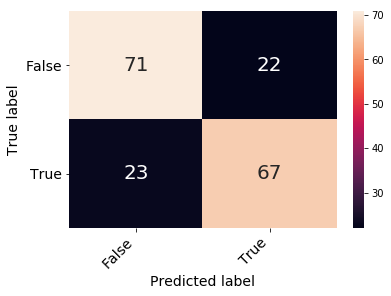

In [81]:
print(randomForest.score(x_test, y_test))
seed = 7
k_fold = KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'
results = results=cross_val_score(randomForest, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'neg_log_loss'
results = results=cross_val_score(randomForest, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("Logloss: %.3f (%.3f)" % (results.mean(), results.std()))
scoring = 'roc_auc'
results = results=cross_val_score(randomForest, x_test, y_test, cv=k_fold, n_jobs=1, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

randomForest.fit(x_train,y_train)
predicted=randomForest.predict(x_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)


confusion_matrix_df = pd.DataFrame(matrix, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

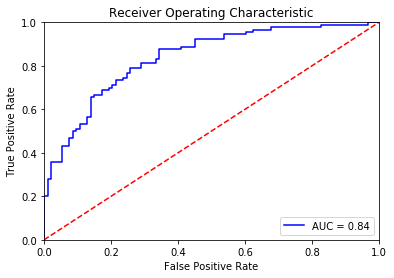

In [82]:
probs = randomForest.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
gold

,y,week_count,week_max_streak,feature_1_mean,feature_1_lifetime_mean,feature_2_mean,feature_2_lifetime_mean,feature_3_mean,feature_3_lifetime_mean,feature_4_mean,feature_4_lifetime_mean,feature_5_mean,feature_5_lifetime_mean,feature_6_mean,feature_6_lifetime_mean,feature_7_mean,feature_7_lifetime_mean,feature_8_mean,feature_8_lifetime_mean
courier,,,,,,,,,,,,,,,,,,,
3767,1,4,3,1.750000,0.875,45.500000,22.750,46.000000,23.000,0.040700,0.020350,0.959300,0.479650,131.828200,65.914100,0.059000,0.029500,2107.008875,1053.504437
6282,0,6,6,1.333333,1.000,36.666667,27.500,48.500000,36.375,0.075517,0.056638,0.924483,0.693362,111.291000,83.468250,0.063467,0.047600,4300.183950,3225.137962
10622,1,2,2,-3.500000,-0.875,84.500000,21.125,54.000000,13.500,0.119050,0.029763,0.880950,0.220238,100.158750,25.039687,0.076200,0.019050,2576.890500,644.222625
13096,0,2,2,0.000000,0.000,59.000000,14.750,89.500000,22.375,0.161600,0.040400,0.838400,0.209600,104.296000,26.074000,0.042800,0.010700,4590.275250,1147.568812
14261,1,8,8,-3.625000,-3.625,75.500000,75.500,70.875000,70.875,0.018425,0.018425,0.981575,0.981575,115.629900,115.629900,0.122925,0.122925,3870.750225,3870.750225
18869,1,2,1,-17.500000,-4.375,117.500000,29.375,61.500000,15.375,0.203600,0.050900,0.796400,0.199100,100.000000,25.000000,0.048800,0.012200,4922.368650,1230.592163
18920,1,5,5,-19.800000,-12.375,122.600000,76.625,46.800000,29.250,0.064080,0.040050,0.935920,0.584950,113.722480,71.076550,0.112740,0.070462,6995.906260,4372.441412
19450,0,1,1,52.000000,6.500,89.000000,11.125,28.000000,3.500,0.321400,0.040175,0.678600,0.084825,138.357100,17.294638,0.178600,0.022325,8228.571400,1028.571425
39517,0,5,3,7.600000,4.750,61.000000,38.125,86.200000,53.875,0.057800,0.036125,0.942200,0.588875,106.311700,66.444812,0.103880,0.064925,3910.566460,2444.104037
